In [40]:
from collections import defaultdict, namedtuple, Counter
import numpy as np
from os import listdir
from itertools import combinations
import scipy.stats as stats
import csv
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import json

In [41]:
phase_dir = '../phased_spark_quads'
identicals_file = '../sibpair_similarity/spark_quads_identicals.txt'
ped_file = '../../DATA/spark/spark.ped.quads.ped'
build = '38'
orig_ped_file = '../../DATA/spark/spark.ped'
data_dir = '../../DATA/spark/genotypes'

#phase_dir = '../phased_ihart.ms2_quads'
#identicals_file = '../sibpair_similarity/ihart.ms2_quads_identicals.txt'
#ped_file = '../../DATA/ihart.ms2/ihart.ped.quads.ped'
#build = '38'
#orig_ped_file = '../../DATA/ihart.ms2/ihart.ped'

#phase_dir = '../phased_mssng_quads'
#identicals_file = '../sibpair_similarity/mssng_quads_identicals.txt'
#ped_file = '../../DATA/mssng/mssng.ped.quads.ped'
#build = '38'
#orig_ped_file = '../../DATA/mssng/mssng.ped'

#phase_dir = '../phased_ssc.hg38'
#identicals_file = '../sibpair_similarity/ssc.hg38_identicals.txt'
#ped_file = '../../DATA/ssc.hg38/ssc.ped'
#build = '38'
#orig_ped_file = '../../DATA/mssng/ssc.ped'

#phase_dir = '../phased_ancestry_quads'
#identicals_file = '../sibpair_similarity/ancestry_quads_identicals.txt'
#ped_file = '../../DATA/ancestry/ancestry.ped.quads.ped'
#build = '37'
#orig_ped_file = '../../DATA/ancestry/ancestry.ped'


In [42]:
chrom = '10'
if build == '37':
    #ctbp2_start_interval, ctbp2_end_interval = 127188569, 127688569
    ctbp2_start_interval, ctbp2_end_interval = 127188569, 128188569
    zeb1_start_interval, zeb1_end_interval = 31607424, 31818742
elif build == '38':
    #ctbp2_start_interval, ctbp2_end_interval = 125500000, 126000000
    ctbp2_start_interval, ctbp2_end_interval = 125500000, 126500000
    zeb1_start_interval, zeb1_end_interval = 31318417, 31529814


In [43]:
def pull_phenotype_ped(ped_file):
	sample_to_sex = dict()
	sample_to_affected = dict()
	with open(ped_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			sample_to_sex[pieces[1]] = pieces[4]
			sample_to_affected[pieces[1]] = pieces[5]
	return sample_to_affected, sample_to_sex

sample_to_affected, sample_to_sex = pull_phenotype_ped(ped_file)


In [44]:
Sibpair = namedtuple('Sibpair', ['family', 'sibling1', 'sibling2', 'mom', 'dad', 'phase_dir', 'num_affected', 'num_males'])
def pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex):

	# pull identicals
	leave_out = set()
	with open(identicals_file, 'r') as f:
		for line in f:
			pieces = line.strip().split('\t')
			leave_out.update(pieces[1:])

	# pull individuals
	family_to_inds = defaultdict(list)
	sibpairs = list()
	for filename in listdir(phase_dir):
		if filename.endswith('.phased.txt'):
			family_key = filename[:-11]
			with open('%s/%s' % (phase_dir, filename), 'r')  as f:
				header = next(f).strip().split('\t')
				# check that we have a typical nuclear family structure
				if tuple(header[1:5]) == ('m1_del', 'm2_del', 'p1_del', 'p2_del'):
					individuals = [header[i][:-4] for i in range(5, len(header)-3, 2)]
					family_to_inds[family_key] = individuals
					for child1, child2 in combinations(individuals[2:], 2):
						if child1 not in leave_out and child2 not in leave_out and child1 in sample_to_affected and child2 in sample_to_affected:
							sibpairs.append(Sibpair(family_key, child1, child2, individuals[0], individuals[1], 
								phase_dir,
								int(sample_to_affected[child1]=='2')+int(sample_to_affected[child2]=='2'),
								int(sample_to_sex[child1]=='1')+int(sample_to_sex[child2]=='1')))

	sibpairs = sorted(sibpairs)

	assert len(sibpairs) == len(set(sibpairs)) # should have no duplicates
	return family_to_inds, sibpairs

family_to_inds, sibpairs = pull_sibpairs(phase_dir, identicals_file, sample_to_affected, sample_to_sex)


In [45]:
print('Overall')
print('families', len(family_to_inds))
print('sibpairs', len(sibpairs))
print('num_affected', Counter([x.num_affected for x in sibpairs]))

Overall
families 4166
sibpairs 3865
num_affected Counter({1: 3100, 2: 676, 0: 89})


In [72]:

def pull_sibpair_matches(sibpairs, family_to_inds, start_interval, end_interval):
    
    length_interval = end_interval-start_interval
    sibpair_to_index = dict([((x.family, x.sibling1, x.sibling2), i) for i, x in enumerate(sibpairs)])

    # pull phase data
    # sibpair, interval, nomatch/match
    is_mat_match = -np.ones((len(sibpair_to_index),), dtype=int)
    is_pat_match = -np.ones((len(sibpair_to_index),), dtype=int)

    for sibpair_index, sibpair in enumerate(sibpairs):
        mat_match_data = np.zeros((2,), dtype=int)
        pat_match_data = np.zeros((2,), dtype=int)
        with open('%s/%s.phased.txt' % (sibpair.phase_dir, sibpair.family), 'r')  as f:
            next(f) # skip header

            for line in f:
                pieces = line.strip().split('\t')
                if pieces[0][3:] == chrom:
                    start_pos, end_pos = [int(x) for x in pieces[-2:]]
                    state = np.array([int(x) for x in pieces[1:-2]])

                    inds = family_to_inds[sibpair.family]
                    sib1_ind_index, sib2_ind_index = inds.index(sibpair.sibling1), inds.index(sibpair.sibling2)
                    sib1_mat_index, sib2_mat_index = 4+2*sib1_ind_index, 4+2*sib2_ind_index
                    sib1_pat_index, sib2_pat_index = 5+2*sib1_ind_index, 5+2*sib2_ind_index

                    overlap = min(end_interval, end_pos) - max(start_interval, start_pos)
                    if overlap > 0:
                        if (state[sib1_mat_index] != -1) and (state[sib2_mat_index] != -1):
                            mat_match_data[int(state[sib1_mat_index]==state[sib2_mat_index])] += overlap

                        if (state[sib1_pat_index] != -1) and (state[sib2_pat_index] != -1):
                            pat_match_data[int(state[sib1_pat_index]==state[sib2_pat_index])] += overlap

        assert np.sum(mat_match_data) <= length_interval
        assert np.sum(pat_match_data) <= length_interval

        if mat_match_data[0]>=0.9*length_interval:
            is_mat_match[sibpair_index] = 0
        if mat_match_data[1]>=0.9*length_interval:
            is_mat_match[sibpair_index] = 1
        if pat_match_data[0]>=0.9*length_interval:
            is_pat_match[sibpair_index] = 0
        if pat_match_data[1]>=0.9*length_interval:
            is_pat_match[sibpair_index] = 1

    return is_mat_match, is_pat_match

ctbp2_is_mat_match, ctbp2_is_pat_match = pull_sibpair_matches(sibpairs, family_to_inds, ctbp2_start_interval, ctbp2_end_interval)
zeb1_is_mat_match, zeb1_is_pat_match = pull_sibpair_matches(sibpairs, family_to_inds, zeb1_start_interval, zeb1_end_interval)



In [786]:
is_aff_aff = np.array([sp.num_affected==2 for sp in sibpairs])
is_aff_typ = np.array([sp.num_affected==1 for sp in sibpairs])
is_typ_typ = np.array([sp.num_affected==0 for sp in sibpairs])

is_m_m = np.array([sp.num_males==2 for sp in sibpairs])
is_m_f = np.array([sp.num_males==1 for sp in sibpairs])
is_f_f = np.array([sp.num_males==0 for sp in sibpairs])

print(np.sum(is_m_m & is_typ_typ), np.sum(is_m_f & is_typ_typ), np.sum(is_f_f & is_typ_typ))

print(np.sum(ctbp2_is_mat_match[is_typ_typ]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ]==1))
print(np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ]==1) + np.sum(ctbp2_is_pat_match[is_typ_typ]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1) + np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_mat_match[is_typ_typ]==1), 
                             np.sum(ctbp2_is_mat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))
print(stats.binom_test(np.sum(ctbp2_is_pat_match[is_typ_typ]==1), 
                              np.sum(ctbp2_is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))

19 48 22
112
167
6.113209877054419e-06
0.05733017787290068
4.250553806845156e-06


In [787]:
c = np.array([[np.sum((ctbp2_is_pat_match==1) & is_typ_typ), np.sum((ctbp2_is_pat_match==0) & is_typ_typ)],
                              [np.sum((ctbp2_is_pat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)]])
print(c)
print(stats.fisher_exact(c))

c = np.array([[np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_typ_typ), np.sum((ctbp2_is_pat_match==0) & is_typ_typ)],
                              [np.sum((ctbp2_is_pat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)]])
print(c)
print(stats.fisher_exact(c))

c = [[np.sum((ctbp2_is_pat_match==1) & is_aff_aff), np.sum((ctbp2_is_pat_match==0) & is_aff_aff)],
                              [np.sum((ctbp2_is_pat_match==1) & is_aff_typ), np.sum((ctbp2_is_pat_match==0) & is_aff_typ)]]
print(c)
print(stats.fisher_exact(c))

[[  65   23]
 [1482 1518]]
(2.8947368421052633, 6.360855257313741e-06)
[[  38   23]
 [1482 1518]]
(1.6923076923076923, 0.05219088000711537)
[[347, 317], [1482, 1518]]
(1.1212276018850815, 0.1839829324754361)


In [816]:
def exact_confidence_interval(count, n):
    p_hat = count/n
    alpha = 0.05
    ps = np.arange(0, 1, 0.0001)

    conf = np.zeros((2, len(count)))
    for i in range(len(count)):
        conf[0, i] = p_hat[i] - ps[np.searchsorted(-stats.binom.cdf(count[i]-1, n[i], ps), -(1 - alpha/2))]
        conf[1, i] = ps[np.searchsorted(-stats.binom.cdf(count[i], n[i], ps), -alpha/2)] - p_hat[i]
        print(i, p_hat[i], conf[:, i], stats.binom_test(count[i], n[i], p=0.25))
    return p_hat, conf

#print(exact_confidence_interval(both_counts, n))


0 0.48717948717948717 [0.11487949 0.11592051] 9.039865422332674e-06
1 0.2465034965034965 [0.0157035 0.0162965] 0.6816394609322682
2 0.2583201267828843 [0.03372013 0.03607987] 0.6457214020748443
0 0.28205128205128205 [0.09605128 0.11334872] 0.5140667703180155
1 0.25034965034965034 [0.01574965 0.01635035] 0.9655570473237541
2 0.2662440570522979 [0.03404406 0.03635594] 0.35783164851107174
0 0.11538461538461539 [0.06118462 0.09241538] 0.005531585079130958
1 0.24475524475524477 [0.01565524 0.01624476] 0.5312192990866411
2 0.24722662440570523 [0.03312662 0.03567338] 0.8904257924272171
0 0.11538461538461539 [0.06118462 0.09241538] 0.005531585079130958
1 0.2583916083916084 [0.01589161 0.01650839] 0.300044111126199
2 0.22820919175911253 [0.03210919 0.03479081] 0.21469037517831446


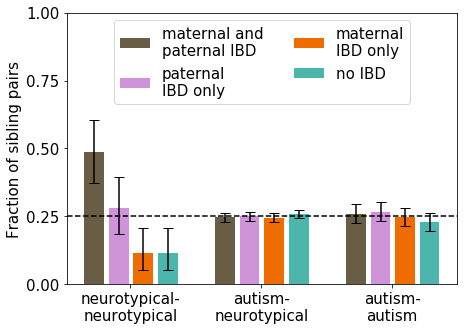

In [827]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']

def plot_with_error(counts, n, x, color, label):
    p_hat, conf = exact_confidence_interval(counts[n!=0], n[n!=0])
    plt.bar(x[n!=0], p_hat, width, 
                 color=color, label=label)
    plt.errorbar(x[n!=0], p_hat, yerr=conf, 
                 color='black', linestyle='', capsize=5)
    

n = np.array([np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_typ_typ), 
              np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_typ), 
              np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_aff)])

both_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_aff)])

pat_only_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_aff)])

mat_only_counts = np.array([np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_aff)])
    
neither_counts = np.array([np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_typ_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_typ),
               np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_aff)])
    
plt.figure(figsize=(7, 5))
width = 0.15

plot_with_error(both_counts, n, np.arange(3), colors[0], 'maternal and\npaternal IBD')
plot_with_error(pat_only_counts, n, np.arange(3)+1.25*width, colors[1], 'paternal\nIBD only')
plot_with_error(mat_only_counts, n, np.arange(3)+2.50*width, colors[2], 'maternal\nIBD only')
plot_with_error(neither_counts, n, np.arange(3)+3.75*width, colors[3], 'no IBD')

plt.axhline(0.25, color='black', linestyle='--')
#plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
plt.xticks(np.arange(3)+1.85*width, ['neurotypical-\nneurotypical', 'autism-\nneurotypical', 'autism-\nautism'])
plt.legend(loc='upper center', ncol=2)
#plt.ylim([0, 1.4])
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylabel('Fraction of sibling pairs')
plt.show()

0 0.48717948717948717 [0.11487949 0.11592051] 9.039865422332674e-06
1 0.28205128205128205 [0.09605128 0.11334872] 0.5140667703180155
2 0.11538461538461539 [0.06118462 0.09241538] 0.005531585079130958
3 0.11538461538461539 [0.06118462 0.09241538] 0.005531585079130958
0 0.2583201267828843 [0.03372013 0.03607987] 0.6457214020748443
1 0.2662440570522979 [0.03404406 0.03635594] 0.35783164851107174
2 0.24722662440570523 [0.03312662 0.03567338] 0.8904257924272171
3 0.22820919175911253 [0.03210919 0.03479081] 0.21469037517831446


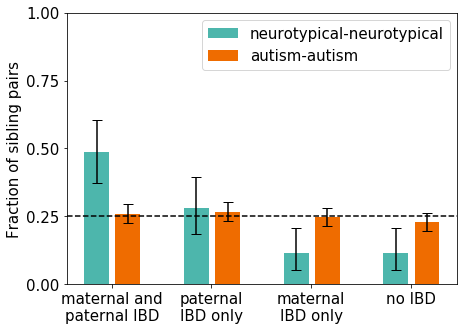

In [828]:
import matplotlib
matplotlib.rcParams.update({'font.size': 15})
colors = ['#695d46ff', '#ce93d8ff', '#ef6c00ff', '#4db6acff']

def plot_with_error(counts, n, x, color, label):
    p_hat, conf = exact_confidence_interval(counts[n!=0], n[n!=0])
    plt.bar(x[n!=0], p_hat, width, 
                 color=color, label=label)
    plt.errorbar(x[n!=0], p_hat, yerr=conf, 
                 color='black', linestyle='', capsize=5)
    

n_typ = np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_typ_typ)
n_aff = np.sum((ctbp2_is_pat_match!=-1) & (ctbp2_is_mat_match!=-1) & is_aff_aff)

typ_typ_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_typ_typ),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_typ_typ)])

aff_aff_counts = np.array([np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==1) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==1) & (ctbp2_is_mat_match==0) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==1) & is_aff_aff),
                           np.sum((ctbp2_is_pat_match==0) & (ctbp2_is_mat_match==0) & is_aff_aff)])
    
plt.figure(figsize=(7, 5))
width = 0.25

plot_with_error(typ_typ_counts, n_typ*np.ones((4,)), np.arange(4), colors[3], 'neurotypical-neurotypical')
plot_with_error(aff_aff_counts, n_aff*np.ones((4,)), np.arange(4)+1.25*width, colors[2], 'autism-autism')

plt.axhline(0.25, color='black', linestyle='--')
#plt.axhline(0.5, color='black', linestyle='--')
#plt.axhline(0.75, color='black', linestyle='--')
plt.xticks(np.arange(4)+0.6*width, ['maternal and\npaternal IBD', 'paternal\nIBD only', 'maternal\nIBD only', 'no IBD'])
plt.legend()
#plt.ylim([0, 1.4])
plt.yticks(np.arange(0, 1.25, 0.25))
plt.ylabel('Fraction of sibling pairs')
plt.show()

In [752]:
stats.chi2_contingency([[np.sum(is_mat_match[is_typ_typ]==1), np.sum(is_pat_match[is_typ_typ]==1)],
                        [np.sum(is_mat_match[is_typ_typ]==0), np.sum(is_pat_match[is_typ_typ]==0)]])

(3.775765226333562, 0.052000110290104415, 1, array([[55.49418605, 59.50581395],
        [27.50581395, 29.49418605]]))

# Detailed Phenotype

In [769]:
# q, typ_response, aff_response
qs = [('q01_phrases', '1', '0'), 
      ('q02_conversation', '1', '0'),
      ('q03_odd_phrase', '0', '1'), 
      ('q04_inappropriate_question', '0', '1'), 
      ('q05_pronouns_mixed', '0', '1'), 
      ('q06_invented_words', '0', '1'), 
      ('q07_same_over', '0', '1'), 
      ('q08_particular_way', '0', '1'), 
      ('q09_expressions_appropriate', '1', '0'), 
      ('q10_hand_tool', '0', '1'), 
      ('q11_interest_preoccupy', '0', '1'), 
      ('q12_parts_object', '0', '1'), 
      ('q13_interests_intensity', '0', '1'), 
      ('q14_senses', '0', '1'), 
      ('q15_odd_ways', '0', '1'),
      ('q16_complicated_movements', '0', '1'), 
      ('q17_injured_deliberately', '0', '1'), 
      ('q18_objects_carry', '0', '1'), 
      ('q19_best_friend', '1', '0'), 
      ('q20_talk_friendly', '1', '0'), 
      ('q21_copy_you', '1', '0'),
      ('q22_point_things', '1', '0'), 
      ('q23_gestures_wanted', '1', '0'), 
      ('q24_nod_head', '1', '0'), 
      ('q25_shake_head', '1', '0'), 
      ('q26_look_directly', '1', '0'), 
      ('q27_smile_back', '1', '0'), 
      ('q28_things_interested', '1', '0'), 
      ('q29_share', '1', '0'), 
      ('q30_join_enjoyment', '1', '0'), 
      ('q31_comfort', '1', '0'),
      ('q32_help_attention', '1', '0'), 
      ('q33_range_expressions', '1', '0'), 
      ('q34_copy_actions', '1', '0'), 
      ('q35_make_believe', '1', '0'), 
      ('q36_same_age', '1', '0'), 
      ('q37_respond_positively', '1', '0'), 
      ('q38_pay_attention', '1', '0'), 
      ('q39_imaginative_games', '1', '0'), 
      ('q40_cooperatively_games', '1', '0')]

ps, ps_mat, ps_pat = [], [], []
for q, typ_response, aff_response in qs:
    child_to_phenotype = dict()
    with open('../phenotypes/spark/scq.csv', 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        q_index = header.index(q)
        for pieces in reader:
            child_to_phenotype[pieces[0]] = pieces[q_index] 

    is_aff_aff = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and child_to_phenotype[sp.sibling1]==aff_response and child_to_phenotype[sp.sibling2]==aff_response for sp in sibpairs])
    is_aff_typ = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and ((child_to_phenotype[sp.sibling1]==aff_response and child_to_phenotype[sp.sibling2]==typ_response) or (child_to_phenotype[sp.sibling1]==typ_response and child_to_phenotype[sp.sibling2]==aff_response)) for sp in sibpairs])
    is_typ_typ = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and child_to_phenotype[sp.sibling1]==typ_response and child_to_phenotype[sp.sibling2]==typ_response for sp in sibpairs])

    #print(np.sum(is_mat_match[is_typ_typ]==1) + np.sum(is_pat_match[is_typ_typ]==1))
    #print(np.sum(is_mat_match[is_typ_typ]!=-1) + np.sum(is_pat_match[is_typ_typ]!=-1))
    #p = stats.binom_test(np.sum((is_mat_match[is_typ_typ]==1) & (is_pat_match[is_typ_typ]==1)), 
    #                     np.sum((is_mat_match[is_typ_typ]!=-1) & (is_pat_match[is_typ_typ]!=-1)),
    #                         p=0.25, alternative='greater')
    p = stats.fisher_exact([[np.sum((is_mat_match[is_typ_typ]==1) & (is_pat_match[is_typ_typ]==1)),
                             np.sum((is_mat_match[is_typ_typ]==0) & (is_pat_match[is_typ_typ]==0))],
                            [np.sum((is_mat_match[is_aff_aff | is_aff_typ]==1) & (is_pat_match[is_aff_aff | is_aff_typ]==1)),
                             np.sum((is_mat_match[is_aff_aff | is_aff_typ]==0) & (is_pat_match[is_aff_aff | is_aff_typ]==0))]])[1]
    
    ps.append(p)
    #ps_mat.append(p_mat)
    #ps_pat.append(p_pat)
    
    print('\n', q, p)
    #print(stats.binom_test(np.sum(is_mat_match[is_aff_typ]==1) + np.sum(is_pat_match[is_aff_typ]==1), 
    #                         np.sum(is_mat_match[is_aff_typ]!=-1) + np.sum(is_pat_match[is_aff_typ]!=-1),
    #                         p=0.5, alternative='less'))
    #print(stats.chi2_contingency([[np.sum(is_mat_match[is_aff_typ]==1) + np.sum(is_pat_match[is_aff_typ]==1), 
    #                         np.sum(is_mat_match[is_aff_typ]!=-1) + np.sum(is_pat_match[is_aff_typ]!=-1),
    #                         p=0.5, alternative='less'))



 q01_phrases 0.126102315190029

 q02_conversation 0.9014459768466953

 q03_odd_phrase 0.3665587622982974

 q04_inappropriate_question 0.8937038806908564

 q05_pronouns_mixed 0.08584796898829218

 q06_invented_words 0.5347361235615224

 q07_same_over 0.1461198411988065

 q08_particular_way 0.01905718014854283

 q09_expressions_appropriate 1.0

 q10_hand_tool 0.13171274682433778

 q11_interest_preoccupy 0.16617397828042102

 q12_parts_object 0.34055748909220496

 q13_interests_intensity 0.12858135881988053

 q14_senses 0.4781117062955218

 q15_odd_ways 0.44613556096202656

 q16_complicated_movements 0.23066440210246197

 q17_injured_deliberately 0.13634117840459672

 q18_objects_carry 0.7976509334987435

 q19_best_friend 0.49263149561532005

 q20_talk_friendly 0.6685084086106423

 q21_copy_you 0.9574105821808294

 q22_point_things 0.752608928979991

 q23_gestures_wanted 0.7494558145781285

 q24_nod_head 0.23773116549199688

 q25_shake_head 0.3777490197088351

 q26_look_directly 0.818994

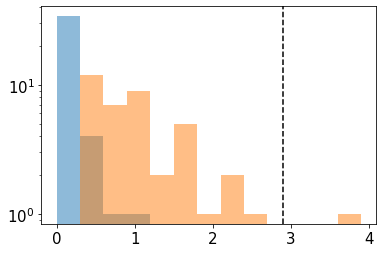

In [754]:
#plt.hist(-np.log10(ps), bins=np.arange(0, 4, 0.3), alpha=0.5, log=True)
plt.hist(-np.log10(ps_mat), bins=np.arange(0, 4, 0.3), alpha=0.5, log=True)
plt.hist(-np.log10(ps_pat), bins=np.arange(0, 4, 0.3), alpha=0.5, log=True)
plt.axvline(-np.log10(0.05/len(ps)), color='black', linestyle='--')
plt.show()

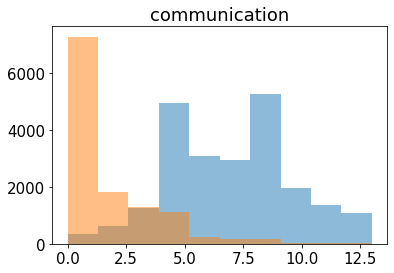

1504 774 14
6 11
6 3
communication
0.08431877195835112 0.6127929687499998 0.02868652343750001



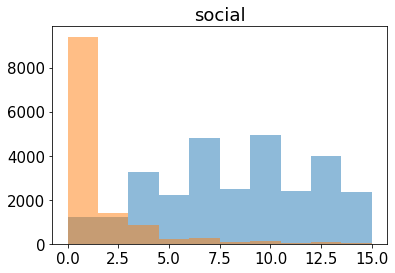

1719 1122 34
16 20
18 14
social
0.3581503800771685 0.69620431936346 0.19576415256597132



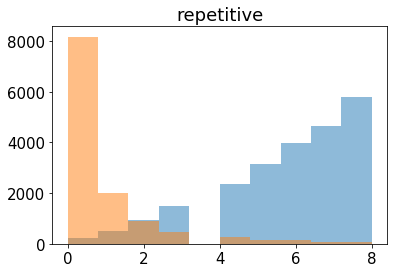

992 1328 44
21 31
19 13
repetitive
0.018764766817206596 0.4373146561902104 0.004779939428317449


In [755]:
# q, typ_response, aff_response
q_groups = [('communication', [('q02_conversation', '1', '0'),
                               ('q03_odd_phrase', '0', '1'), 
                               ('q04_inappropriate_question', '0', '1'), 
                               ('q05_pronouns_mixed', '0', '1'), 
                               ('q06_invented_words', '0', '1'),
                               ('q20_talk_friendly', '1', '0'), 
                               ('q21_copy_you', '1', '0'),
                               ('q22_point_things', '1', '0'), 
                               ('q23_gestures_wanted', '1', '0'), 
                               ('q24_nod_head', '1', '0'), 
                               ('q25_shake_head', '1', '0'), 
                               ('q34_copy_actions', '1', '0'), 
                               ('q35_make_believe', '1', '0')]),
            ('social', [('q09_expressions_appropriate', '1', '0'),
                        ('q10_hand_tool', '0', '1'), 
                        ('q19_best_friend', '1', '0'), 
                        ('q26_look_directly', '1', '0'), 
                        ('q27_smile_back', '1', '0'), 
                        ('q28_things_interested', '1', '0'), 
                        ('q29_share', '1', '0'), 
                        ('q30_join_enjoyment', '1', '0'), 
                        ('q31_comfort', '1', '0'),
                        ('q32_help_attention', '1', '0'), 
                        ('q33_range_expressions', '1', '0'), 
                        ('q36_same_age', '1', '0'), 
                        ('q37_respond_positively', '1', '0'),
                        ('q39_imaginative_games', '1', '0'), 
                        ('q40_cooperatively_games', '1', '0')]),
            ('repetitive', [('q07_same_over', '0', '1'), 
                            ('q08_particular_way', '0', '1'),
                            ('q11_interest_preoccupy', '0', '1'), 
                            ('q12_parts_object', '0', '1'), 
                            ('q13_interests_intensity', '0', '1'), 
                            ('q14_senses', '0', '1'), 
                            ('q15_odd_ways', '0', '1'),
                            ('q16_complicated_movements', '0', '1')])
           ]

for g, qs in q_groups:
    print()
    child_to_phenotype = dict()
    child_to_asd = dict()
    with open('../phenotypes/spark/scq.csv', 'r') as f:
        reader = csv.reader(f)
        header = next(reader)
        q_indices = [header.index(q[0]) for q in qs]
        asd_index = header.index('asd')
        for pieces in reader:
            responses = [pieces[q_index] for q_index in q_indices]
            if np.all([r==typ or r==aff for r, (_, typ, aff) in zip(responses, qs)]):
                child_to_phenotype[pieces[0]] = np.sum([r==aff for r, (_, _, aff) in zip(responses, qs)]) 
                child_to_asd[pieces[0]] = pieces[asd_index]

    plt.hist([child_to_phenotype[x] for x in child_to_phenotype.keys() if child_to_asd[x]=='TRUE'], alpha=0.5)
    plt.hist([child_to_phenotype[x] for x in child_to_phenotype.keys() if child_to_asd[x]=='FALSE'], alpha=0.5)
    plt.title(g)
    plt.show()

    cutoff = 0
    is_aff_aff = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and child_to_phenotype[sp.sibling1]>cutoff and child_to_phenotype[sp.sibling2]>cutoff for sp in sibpairs])
    is_aff_typ = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and ((child_to_phenotype[sp.sibling1]>cutoff and child_to_phenotype[sp.sibling2]<=cutoff) or (child_to_phenotype[sp.sibling1]<=cutoff and child_to_phenotype[sp.sibling2]>cutoff)) for sp in sibpairs])
    is_typ_typ = np.array([sp.sibling1 in child_to_phenotype and sp.sibling2 in child_to_phenotype and child_to_phenotype[sp.sibling1]<=cutoff and child_to_phenotype[sp.sibling2]<=cutoff for sp in sibpairs])

    print(np.sum(is_aff_aff), np.sum(is_aff_typ), np.sum(is_typ_typ))
    
    print(np.sum(is_mat_match[is_typ_typ]==1), np.sum(is_pat_match[is_typ_typ]==1))
    print(np.sum(is_mat_match[is_typ_typ]==0), np.sum(is_pat_match[is_typ_typ]==0))
    p = stats.binom_test(np.sum(is_mat_match[is_typ_typ]==1) + np.sum(is_pat_match[is_typ_typ]==1), 
                             np.sum(is_mat_match[is_typ_typ]!=-1) + np.sum(is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater')
    p_mat = stats.binom_test(np.sum(is_mat_match[is_typ_typ]==1), 
                             np.sum(is_mat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater')
    p_pat = stats.binom_test(np.sum(is_pat_match[is_typ_typ]==1), 
                             np.sum(is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater')
    
    print(g)
    print(p, p_mat, p_pat)

    #print(stats.binom_test(np.sum(is_mat_match[is_aff_typ]==1) + np.sum(is_pat_match[is_aff_typ]==1), 
    #                         np.sum(is_mat_match[is_aff_typ]!=-1) + np.sum(is_pat_match[is_aff_typ]!=-1),
    #                         p=0.5, alternative='less'))
    #print(stats.chi2_contingency([[np.sum(is_mat_match[is_aff_typ]==1) + np.sum(is_pat_match[is_aff_typ]==1), 
    #                         np.sum(is_mat_match[is_aff_typ]!=-1) + np.sum(is_pat_match[is_aff_typ]!=-1),
    #                         p=0.5, alternative='less'))


In [756]:
print(np.sum(is_mat_match[is_typ_typ]==1) + np.sum(is_pat_match[is_typ_typ]==1))
print(np.sum(is_mat_match[is_typ_typ]!=-1) + np.sum(is_pat_match[is_typ_typ]!=-1))
print(stats.binom_test(np.sum(is_mat_match[is_typ_typ]==1) + np.sum(is_pat_match[is_typ_typ]==1), 
                             np.sum(is_mat_match[is_typ_typ]!=-1) + np.sum(is_pat_match[is_typ_typ]!=-1),
                             p=0.5, alternative='greater'))


52
84
0.018764766817206596


In [757]:
family_to_num_affected = defaultdict(set)
with open(orig_ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if pieces[5]=='2':
            family_to_num_affected[pieces[0]].add(pieces[1])
            
is_multiplex = np.array([len(family_to_num_affected[x.family.split('.')[0]])>=2 for x in sibpairs])
print(np.sum(is_multiplex), np.sum(~is_multiplex))

1275 2590


In [758]:
print(len([sibpairs[i] for i in np.where((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & is_multiplex)[0]]))

print(np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & ~is_multiplex))


14
14 1


In [759]:
print(np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & ~is_multiplex))


5 1


In [760]:
print(np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & ~is_multiplex))



9 5


In [761]:
print(np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & is_multiplex),
      np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & ~is_multiplex))

3 2


In [762]:
c = [
    [
        2*np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & is_multiplex),
        2*np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & is_multiplex)
    ],
    [
        2*np.sum((is_mat_match==1) & (is_pat_match==1) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & ~is_multiplex),
        2*np.sum((is_mat_match==0) & (is_pat_match==0) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==1) & (is_pat_match==0) & is_typ_typ & ~is_multiplex) + \
        np.sum((is_mat_match==0) & (is_pat_match==1) & is_typ_typ & ~is_multiplex)
    ]]
print(c)
print(stats.chi2_contingency(c))

[[42, 20], [8, 10]]
(2.3130227001194745, 0.1282943498111398, 1, array([[38.75, 23.25],
       [11.25,  6.75]]))


In [46]:
with open('%s/samples.json' % data_dir, 'r') as f:
    samples = json.load(f)
sample_to_index = dict([(x, i) for i, x in enumerate(samples)])
    
coords = np.load('%s/chr.10.0.gen.coordinates.npy' % data_dir)
af = np.load('%s/chr.10.0.gen.af.npy' % data_dir)
gen = sparse.load_npz('%s/chr.10.0.gen.npz' % data_dir)


In [47]:
indices = (coords[:, 1]>=ctbp2_start_interval) & (coords[:, 1]<=ctbp2_end_interval) & (coords[:, 2]==1) & (coords[:, 3]==1)
print(np.sum(indices))

286


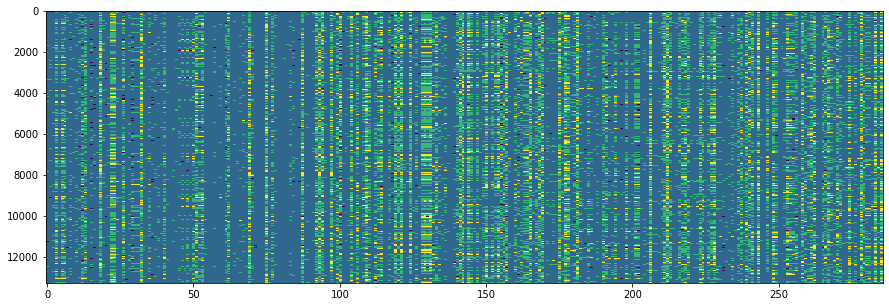

In [48]:
plt.figure(figsize=(15, 5))
plt.imshow(gen[:, indices].A, aspect='auto')
plt.show()

In [49]:
has_autism = np.array([x in sample_to_affected and sample_to_affected[x]=='2' for x in samples])
no_autism = np.array([x in sample_to_affected and sample_to_affected[x]=='1' for x in samples])
print(np.sum(has_autism), np.sum(no_autism))

3881 2891


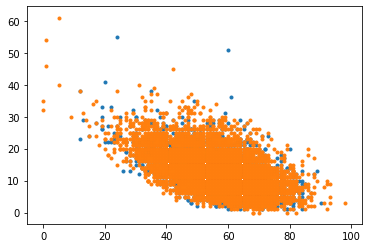

In [50]:
plt.scatter(np.sum(gen[:, indices].A[has_autism, :]==1, axis=1), np.sum(gen[:, indices].A[has_autism, :]==2, axis=1), marker='.')
plt.scatter(np.sum(gen[:, indices].A[~has_autism, :]==1, axis=1), np.sum(gen[:, indices].A[~has_autism, :]==2, axis=1), marker='.')
plt.show()

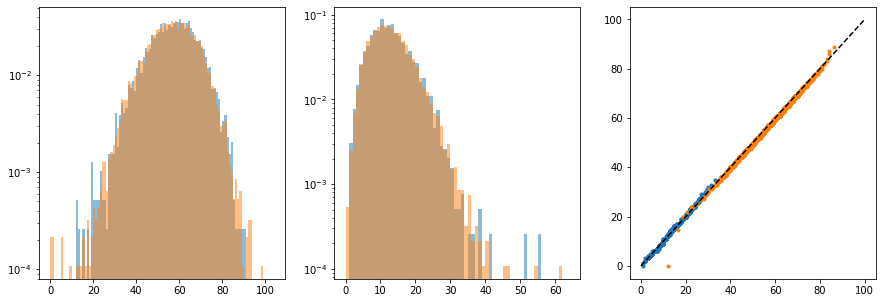

In [51]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.hist(np.sum(gen[:, indices].A[has_autism, :]==1, axis=1), bins=np.arange(105), density=True, alpha=0.5, log=True)
plt.hist(np.sum(gen[:, indices].A[~has_autism, :]==1, axis=1), bins=np.arange(105), density=True, alpha=0.5, log=True)

plt.subplot(1, 3, 2)
plt.hist(np.sum(gen[:, indices].A[has_autism, :]==2, axis=1), bins=np.arange(65), density=True, alpha=0.5, log=True)
plt.hist(np.sum(gen[:, indices].A[~has_autism, :]==2, axis=1), bins=np.arange(65), density=True, alpha=0.5, log=True)

plt.subplot(1, 3, 3)
plt.scatter(np.quantile(np.sum(gen[:, indices].A[has_autism, :]==2, axis=1), np.arange(0, 1, 0.001)),
            np.quantile(np.sum(gen[:, indices].A[~has_autism, :]==2, axis=1), np.arange(0, 1, 0.001)), marker='.')
plt.scatter(np.quantile(np.sum(gen[:, indices].A[has_autism, :]==1, axis=1), np.arange(0, 1, 0.001)),
            np.quantile(np.sum(gen[:, indices].A[~has_autism, :]==1, axis=1), np.arange(0, 1, 0.001)), marker='.')
plt.plot([0, 100], [0, 100], color='black', linestyle='--')
plt.show()

In [59]:
print(stats.ttest_ind(np.sum(gen[:, indices].A[has_autism, :]==1, axis=1),
                      np.sum(gen[:, indices].A[~has_autism, :]==1, axis=1)))

Ttest_indResult(statistic=2.2984246639265526, pvalue=0.021553128339276244)


In [67]:
num_het_aff = []
num_het_unaff = []
for sibpair in sibpairs:
    if sibpair.num_affected == 1:
        if sample_to_affected[sibpair.sibling1]=='2' and sample_to_affected[sibpair.sibling2]=='1':
            num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1))
            num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1))
        elif sample_to_affected[sibpair.sibling1]=='1' and sample_to_affected[sibpair.sibling2]=='2':
            num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1))
            num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1))
        else:
            print('Problem')
            

In [79]:
num_het_aff = np.array(num_het_aff)
num_het_unaff = np.array(num_het_unaff)


[0 1 1 ... 1 1 0]


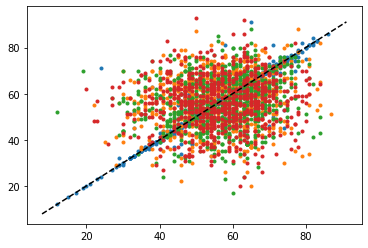

In [92]:
mm = np.array([x for x, sibpair in zip(ctbp2_is_mat_match, sibpairs) if sibpair.num_affected==1]).astype(bool)
pm = np.array([x for x, sibpair in zip(ctbp2_is_pat_match, sibpairs) if sibpair.num_affected==1]).astype(bool)
plt.scatter(num_het_aff[mm & pm], num_het_unaff[mm & pm], marker='.')
plt.scatter(num_het_aff[mm & ~pm], num_het_unaff[mm & ~pm], marker='.')
plt.scatter(num_het_aff[~mm & pm], num_het_unaff[~mm & pm], marker='.')
plt.scatter(num_het_aff[~mm & ~pm], num_het_unaff[~mm & ~pm], marker='.')
plt.plot(plt.xlim(), plt.xlim(), color='black', linestyle='--')
plt.show()

In [91]:
print(np.sum(np.array(num_het_aff)>np.array(num_het_unaff)))
print(np.sum(np.array(num_het_aff)<np.array(num_het_unaff)))
print(np.sum(np.array(num_het_aff)==np.array(num_het_unaff)))

print(stats.binom_test(np.sum(num_het_aff[mm & pm]>num_het_unaff[mm & pm]), np.sum(num_het_aff[mm & pm]!=num_het_unaff[mm & pm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[mm & ~pm]>num_het_unaff[mm & ~pm]), np.sum(num_het_aff[mm & ~pm]!=num_het_unaff[mm & ~pm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[~mm & pm]>num_het_unaff[~mm & pm]), np.sum(num_het_aff[~mm & pm]!=num_het_unaff[~mm & pm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[~mm & ~pm]>num_het_unaff[~mm & ~pm]), np.sum(num_het_aff[~mm & ~pm]!=num_het_unaff[~mm & ~pm]), alternative='greater'))
print()
print(stats.binom_test(np.sum(num_het_aff[mm]>num_het_unaff[mm]), np.sum(num_het_aff[mm]!=num_het_unaff[mm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[pm]>num_het_unaff[pm]), np.sum(num_het_aff[pm]!=num_het_unaff[pm]), alternative='greater'))
print()
print(stats.binom_test(np.sum(num_het_aff[~mm]>num_het_unaff[~mm]), np.sum(num_het_aff[~mm]!=num_het_unaff[~mm]), alternative='greater'))
print(stats.binom_test(np.sum(num_het_aff[~pm]>num_het_unaff[~pm]), np.sum(num_het_aff[~pm]!=num_het_unaff[~pm]), alternative='greater'))
print()
print(stats.binom_test(np.sum(num_het_aff>num_het_unaff), np.sum(num_het_aff!=num_het_unaff), alternative='greater'))



1286
1223
591
0.34455199303050726
0.9373412694094969
0.014568168099188818
0.09603520693714412

0.8521710588176694
0.01875643305104364

0.006318282695213842
0.5621530738469471

0.1078958805619051


In [57]:
print(stats.ttest_rel(num_het_aff, num_het_unaff))

Ttest_relResult(statistic=0.6837116430350999, pvalue=0.4942083867350928)


In [61]:
num_het_aff = []
num_het_unaff = []
for sibpair in sibpairs:
    par_avg = 0.5*(np.sum(gen[sample_to_index[sibpair.mom], indices].A==1) + np.sum(gen[sample_to_index[sibpair.dad], indices].A==1))
    if sample_to_affected[sibpair.sibling1]=='2':
        num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1) - par_avg)
    elif sample_to_affected[sibpair.sibling1]=='1':
        num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling1], indices].A==1) - par_avg)
        
    if sample_to_affected[sibpair.sibling2]=='2':
        num_het_aff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1) - par_avg)
    elif sample_to_affected[sibpair.sibling2]=='1':
        num_het_unaff.append(np.sum(gen[sample_to_index[sibpair.sibling2], indices].A==1) - par_avg)


In [62]:
print(stats.ttest_ind(num_het_aff, num_het_unaff))

Ttest_indResult(statistic=1.2001225757942358, pvalue=0.23012852722439786)


In [319]:
gen_data = gen[:, indices].A
gen_data[gen_data<0] = 0
num_alleles_aut = np.sum(gen_data[has_autism, :], axis=0)
num_alleles_typ = np.sum(gen_data[no_autism, :], axis=0)


In [320]:
af_bins = np.array([10**-x for x in np.arange(0, 5, 0.1)])
af_bin_aut_counts = np.zeros((af_bins.shape[0]+1,), dtype=int)
af_bin_typ_counts = np.zeros((af_bins.shape[0]+1,), dtype=int)
print(af_bins)

[1.00000000e+00 7.94328235e-01 6.30957344e-01 5.01187234e-01
 3.98107171e-01 3.16227766e-01 2.51188643e-01 1.99526231e-01
 1.58489319e-01 1.25892541e-01 1.00000000e-01 7.94328235e-02
 6.30957344e-02 5.01187234e-02 3.98107171e-02 3.16227766e-02
 2.51188643e-02 1.99526231e-02 1.58489319e-02 1.25892541e-02
 1.00000000e-02 7.94328235e-03 6.30957344e-03 5.01187234e-03
 3.98107171e-03 3.16227766e-03 2.51188643e-03 1.99526231e-03
 1.58489319e-03 1.25892541e-03 1.00000000e-03 7.94328235e-04
 6.30957344e-04 5.01187234e-04 3.98107171e-04 3.16227766e-04
 2.51188643e-04 1.99526231e-04 1.58489319e-04 1.25892541e-04
 1.00000000e-04 7.94328235e-05 6.30957344e-05 5.01187234e-05
 3.98107171e-05 3.16227766e-05 2.51188643e-05 1.99526231e-05
 1.58489319e-05 1.25892541e-05]


In [321]:
af_bin_aut_counts[np.digitize(af[indices], af_bins)] += num_alleles_aut
af_bin_typ_counts[np.digitize(af[indices], af_bins)] += num_alleles_typ

//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
//anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


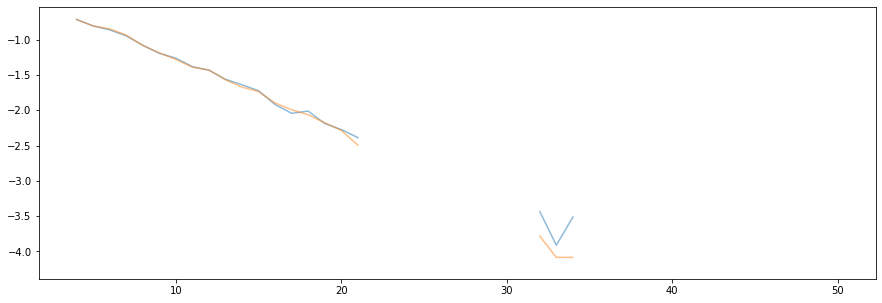

In [329]:
plt.figure(figsize=(15, 5))
plt.plot(np.log10(af_bin_aut_counts/np.sum(af_bin_aut_counts)), alpha=0.5)
plt.plot(np.log10(af_bin_typ_counts/np.sum(af_bin_typ_counts)), alpha=0.5)
plt.show()

In [332]:
print(np.sum(af_bin_aut_counts[20:]))
print(np.sum(af_bin_typ_counts[20:]))

199
128


In [334]:
rare_indices = (coords[:, 1]>=start_interval) & (coords[:, 1]<=end_interval) & (coords[:, 2]==1) & (coords[:, 3]==1) & (af<=0.01)
print(np.sum(rare_indices))

22


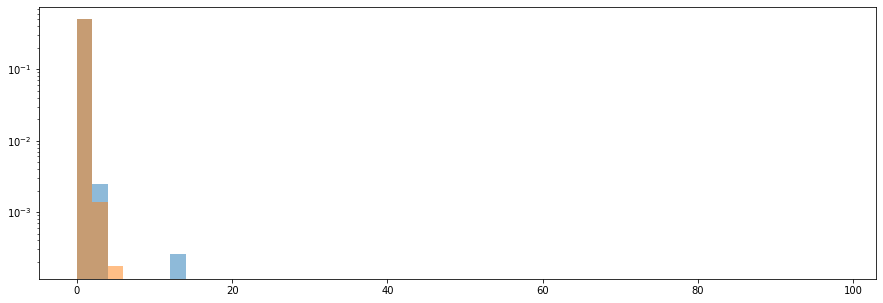

In [348]:
rare_gen_data = gen[:, rare_indices].A
rare_gen_data[rare_gen_data<0] = 0

plt.figure(figsize=(15, 5))

plt.hist(np.sum(rare_gen_data[has_autism, :], axis=1), alpha=0.5, bins=np.arange(0, 100, 2), density=True, log=True)
plt.hist(np.sum(rare_gen_data[no_autism, :], axis=1), alpha=0.5, bins=np.arange(0, 100, 2), density=True, log=True)
plt.show()

In [350]:
print(stats.ttest_ind(np.sum(gen_data[has_autism, :], axis=1), np.sum(gen_data[no_autism, :], axis=1)))
print(stats.ttest_ind(np.sum(rare_gen_data[has_autism, :], axis=1), np.sum(rare_gen_data[no_autism, :], axis=1)))

Ttest_indResult(statistic=1.113230268760339, pvalue=0.26564906997354887)
Ttest_indResult(statistic=1.2027245065123269, pvalue=0.22912500829869908)
